In [2]:
#import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn as sk
import scipy.io as sio



In [3]:
#Function Section

def gaussian_kernel_trial(x, x_i, bandwidth): #fucntion to get the k_h kernel of y (distance)
    #k_h(y) = h^-1 k(y/h)  
    #where k(y/h) = (2pi)^(-1/2)e^(-1/2 (y/h)^2)
    distance = np.linalg.norm(x - x_i)
    kernel = (2*np.pi)**(-1/2)*np.exp((-1/2)*(distance)**2/bandwidth)
    return kernel

#Kernel Funciton 
def gaussian_kernel(x, x_i, bandwidth):
    distance = np.linalg.norm(x - x_i)
    kernel = np.exp((-1/2)*(distance/bandwidth)**2)
    return kernel

# Computing the leave one out
def compute_leave_one_out_cross_val(data, bandwidth):
    loocv_errors = []
    for i in range(len(data)):
        leave_out_data = np.delete(data, i)  # leave out data point at index i
        kde_estimate = kde(data[i], leave_out_data, bandwidth)
        squared_error = (kde_estimate - gaussian_kernel(data[i], data[i], bandwidth))**2
        loocv_errors.append(squared_error)
    return np.sqrt(np.mean(loocv_errors)) #return the RMSE of error

# KDE function
def kde(x, data, bandwidth):
    n = len(data)
    kde_estimate = np.zeros_like(x)
    for i in range(n):
        kde_estimate += gaussian_kernel(x, data[i], bandwidth)
    return kde_estimate / (n * bandwidth)

# Least squared LOOCV algorithm
def least_squared_loocv(data):
    n = len(data)
    min_error = float('inf')
    best_bandwidth = None
    for bandwidth in np.linspace(0.1, 1.9, 100):  # Adjust the bandwidth range as needed
        total_error = 0
        for i in range(n):
            leave_out_data = np.delete(data, i)
            kde_estimate = kde(data[i], leave_out_data, bandwidth)
            squared_error = (kde_estimate - gaussian_kernel(data[i], data[i], bandwidth))**2
            total_error += squared_error
        mean_error = np.mean(total_error)
        if mean_error < min_error:
            min_error = mean_error
            best_bandwidth = bandwidth
    return best_bandwidth

#outlier score 1 from the document
def outlier_score_1(x, X, h):
    n = len(X)
    f_hat_x = kde(x, X, h)
    neighbor_sum = np.sum([kde(X[i], X, h) for i in range(n)]) - f_hat_x
    return n * f_hat_x / neighbor_sum

#outlier score 2 from the document
def outlier_score_2(x, X, k):
    distances = np.abs(X - x)
    sorted_indices = np.argsort(distances)
    k_nearest_distances = distances[sorted_indices[:k]]
    return 1 / (k * np.mean(k_nearest_distances))


In [4]:
#Load the data

#load data from matrix file, anomaly

dataset = sio.loadmat('Data/anomaly.mat')
X = dataset['X'][0]
xtest1 = dataset['xtest1'][0][0]
xtest2 = dataset['xtest2'][0][0]


#from this file we have the X value, but we need to find the density function f

print(f'xtest point1: {xtest1}')
print(f'xtest point2: {xtest2}')

print(f'X set size: {X.shape}')

xtest point1: 2.85
xtest point2: -1.5
X set size: (500,)


In [5]:
#Part A) Figure out the bandwidth parameter first

#solve for the best bandwidth for the problem
optimal_bandwidth = least_squared_loocv(X)
print("Optimal bandwidth:", optimal_bandwidth)
    


[0.2816269444479745, 0.25928330559213, 0.24311051731041036, 0.23042212277596422, 0.21996159551518993, 0.2110368062728145, 0.20322802616245203, 0.19626406200046195, 0.18996147046106027, 0.18419162038332293, 0.17886155588165523, 0.17390229935731177, 0.1692614229181934, 0.16489818636031361, 0.16078027546718304, 0.1568815674335649, 0.15318057137942345, 0.14965932159572642, 0.1463025797703202, 0.1430972514103394, 0.1400319528869987, 0.13709668581058446, 0.13428258884889974, 0.1315817460963125, 0.12898703721632657, 0.1264920187905188, 0.12409082923761547, 0.12177811172861953, 0.1195489509892659, 0.11739882093226214, 0.11532354082268845, 0.113319238235565, 0.11138231747377494, 0.10950943241836462, 0.10769746301068034, 0.10594349473741853, 0.1042448006201837, 0.10259882531118504, 0.10100317097397091, 0.09945558468824102, 0.09795394716494153, 0.09649626259511916, 0.0950806494856811, 0.09370533235900357, 0.09236863421255578, 0.09106896965034543, 0.0898048386108081, 0.08857482062633326, 0.0873775

2.9860944369718396
-0.8488067922838691


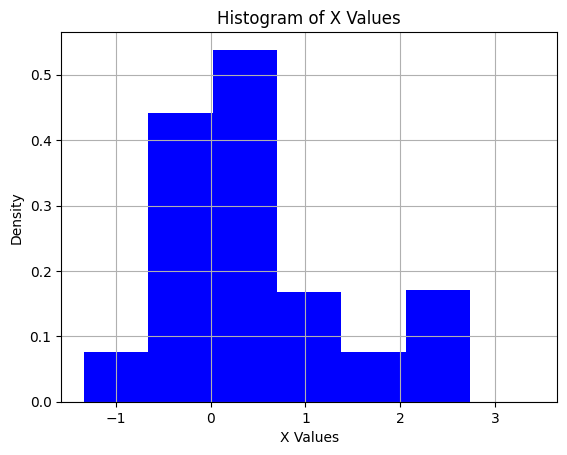

In [8]:
#Getting the histrogram for a sanity check
print(np.max(X))
print(np.min(X))
width = 0.68
bin_edges = np.arange(-1,4.25,width)
hist, _ = np.histogram(X,bins=bin_edges,density=True)
# Plot histogram
plt.bar(bin_edges[:-1],hist,width=width,color='blue')
plt.title('Histogram of X Values')
plt.xlabel('X Values')
plt.ylabel('Density')
plt.grid(True)
plt.show()

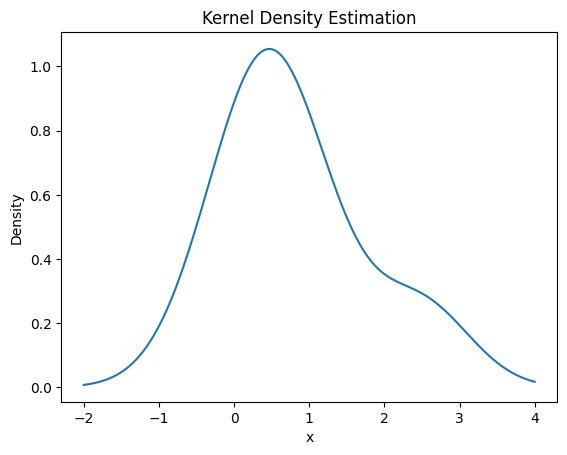

In [9]:
#Part B, estimate the density function f between -2 and 4 

#plot the kde, from -2 to 4
x_values = np.linspace(-2, 4, 500)
kde_values = [kde(x, X, optimal_bandwidth) for x in x_values]
plt.plot(x_values, kde_values)
plt.title('Kernel Density Estimation')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()


